In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from oiffile import imread
import random
import glob
import torch
import sys
sys.path.insert(0, '..')
from other import dognet
from other import functions
import skimage
from skimage.transform import resize
import tifffile as tiff
import torch
from tqdm import tnrange
from skimage import data

In [5]:
# load networks
networks = []
for i in range(0,10):
    netName = "../networks/multipleNetworks-vermisB/net%s" % (i)
    net = torch.load(netName)
    networks.append(net)
# load and clip pre-computed medians/means of slices
medianTotal= np.double(np.load("../../datasets/vermisB/normalizationMatrices/medianTotal.npy"))
meanTotal= np.double(np.load("../../datasets/vermisB/normalizationMatrices/meanTotal.npy"))

medianclipped0 = np.maximum(medianTotal[0],np.max(medianTotal[0])*0.6)
medianclipped1 = np.maximum(medianTotal[1],np.max(medianTotal[1])*0.6)
medianclipped2 = np.maximum(meanTotal[2],np.max(meanTotal[2])*0.6)

In [7]:
#get training masks
path1 = glob.glob("../../datasets/vermisB/trainingMasks/*.npy")
trainingMasks = functions.get_trainingMasks(path1)
#get and scale training images
path2 = glob.glob("../../datasets/vermisB/trainingImages/*.npy")
trainingImages,collman = functions.get_trainingImages(path2,20,22,25)

In [9]:
# generate predicted synapse maps for all test images of network
testNums = [183,162,19,67,152,119,49,159,40,101,167,133,90,75,156,2,148,31,63,131,192,176,56,14,132,172,121,108,171,116,196,177,160,137,84,122,178,64,115,37,140,169,88,11,195,68,69,48,118,71]
# open image names
with open("../../datasets/vermisB/imagesUsed-vermisB.txt") as fin:
    lines = fin.readlines()
    lines.sort()
# set synapse pixel intensity threshold
threshold = .1

In [10]:
# save predicted masks for viewing
predImgs = []
# record correctly identified synpases per image
truePos = []
# sum of true synapses
truePositives = 0
# sum of total synapses
coordsLen = 0
# loop through all test images
for x in testNums:
    inimg = np.transpose(resize(np.transpose(trainingImages[x],(2,1,0)),(230,230)),(2,0,1))
    outimages = []
    # get predicted mask from each network
    for netnum in networks:
        outname = functions.inference(netnum.to(torch.device("cuda")),inimg,get_inter=False,device=torch.device("cuda"))
        outimages.append(outname)
    # take median predicted image
    outimg = np.median(np.asarray(outimages), axis=0)
    predictedMask = outimg[0]
    predictedMask = np.flip(np.flip(predictedMask.transpose(1,0)))
    # get image name
    num = int(x/4)
    if x%4 == 0:
        quad = "LL"
    elif x%4 == 1:
        quad = "LR"
    elif x%4 == 2:
        quad = "UL"
    elif x%4 == 3:
        quad = "UR"
    fname = lines[num]
    fname = fname[:12]
    # get image coordinates
    imageName = "../../datasets/vermisB/trainingCoordinates/%s_%s_coords" % (fname,quad)
    with open(imageName) as fi:
        coors = fi.readlines()
        
    coordins = [[] for j in range(0,len(coors))]
    # check each coordinate on the predicted mask
    for i in range(0,len(coors)):
        xy = coors[i].split(",")
        xy[1]=xy[1][:24]
        xy[0]=float(xy[0])
        xy[1]=float(xy[1])
        coordins[i]=np.array(xy)
        
    correctSynapse = 0
    # mark as true positive if pixel intensity exceeds threshold    
    for k in coordins:
        if predictedMask[int(k[1])][int(k[0])] > threshold:
            correctSynapse += 1
    # update values
    truePos.append(("%s/%s") %(correctSynapse, len(coordins)))
    truePositives+=correctSynapse
    coordsLen+=len(coordins)
    predImgs.append(predictedMask)

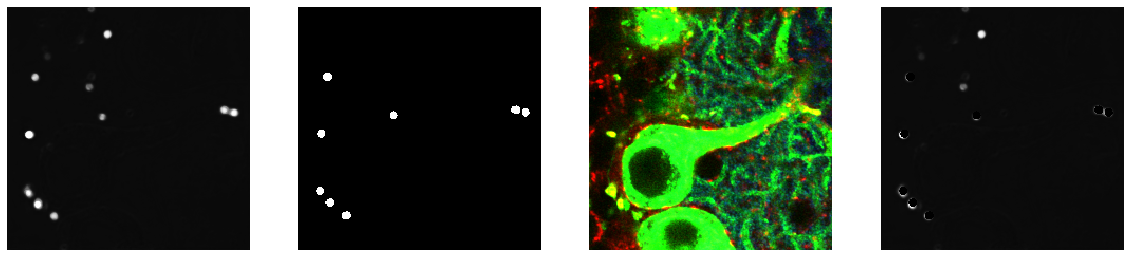

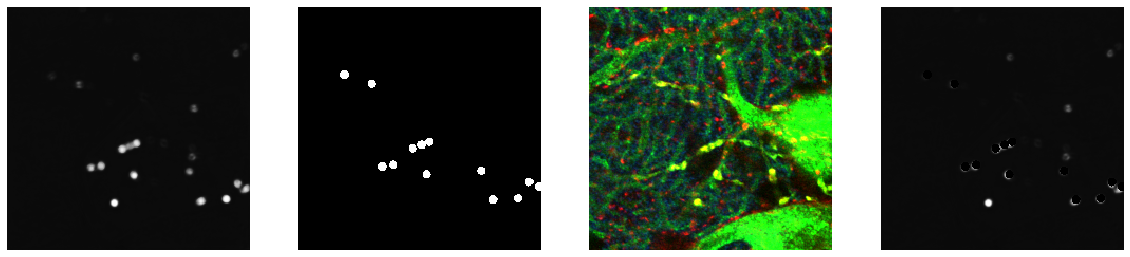

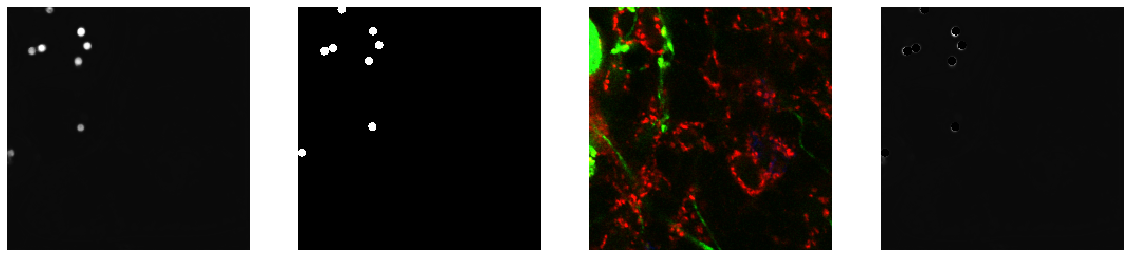

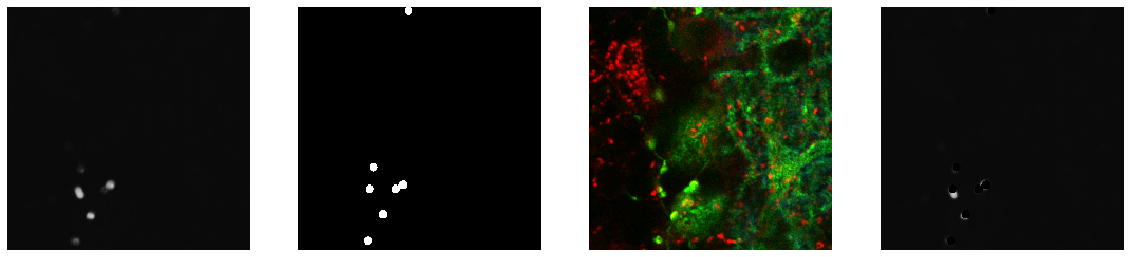

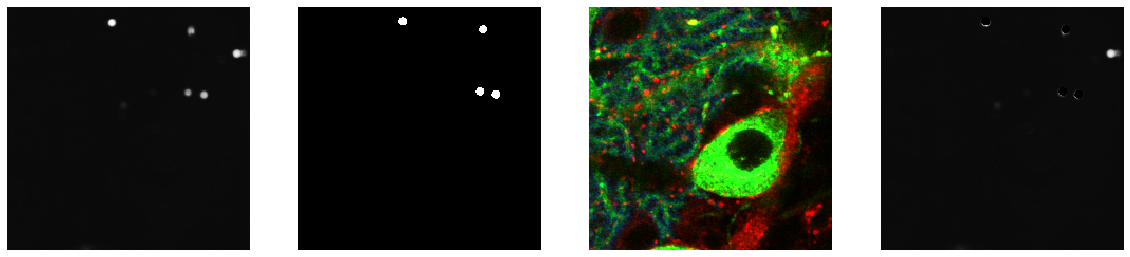

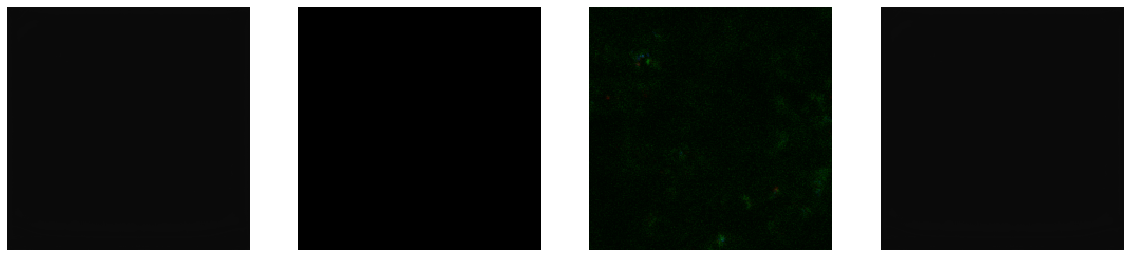

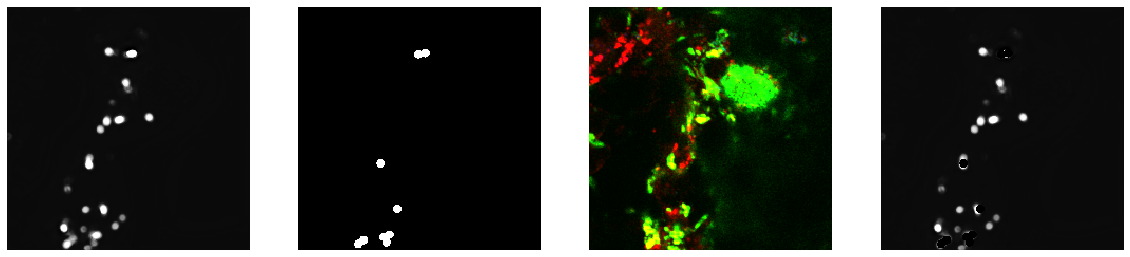

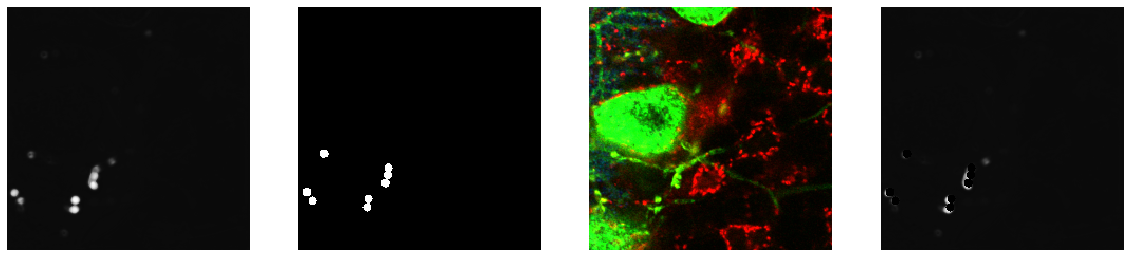

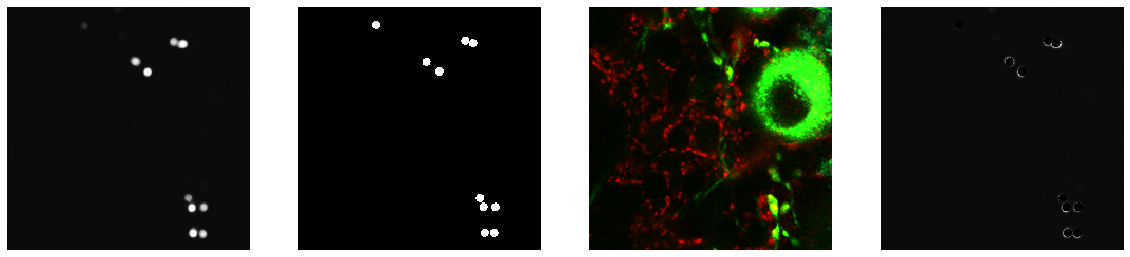

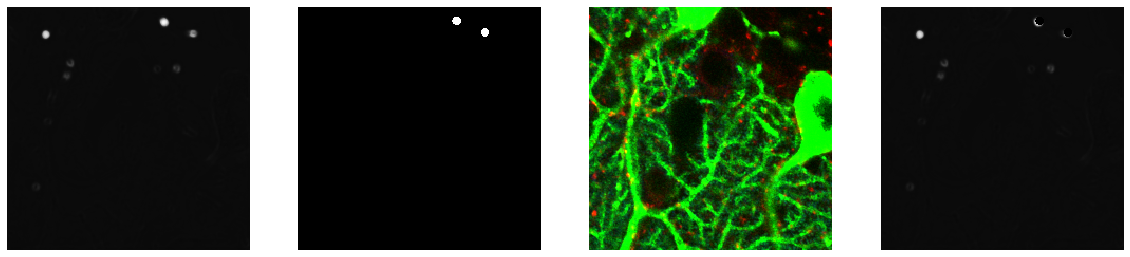

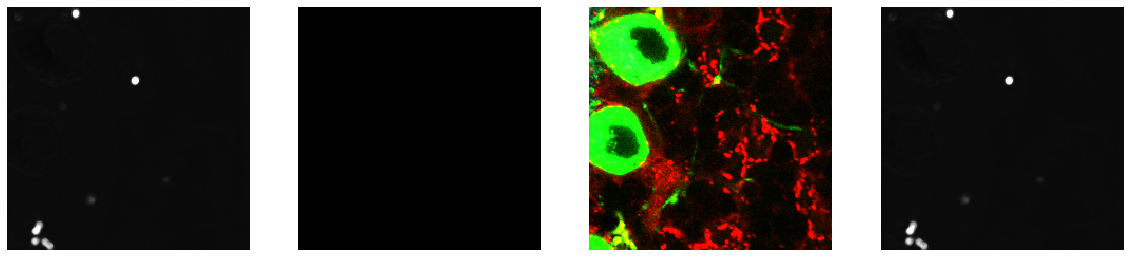

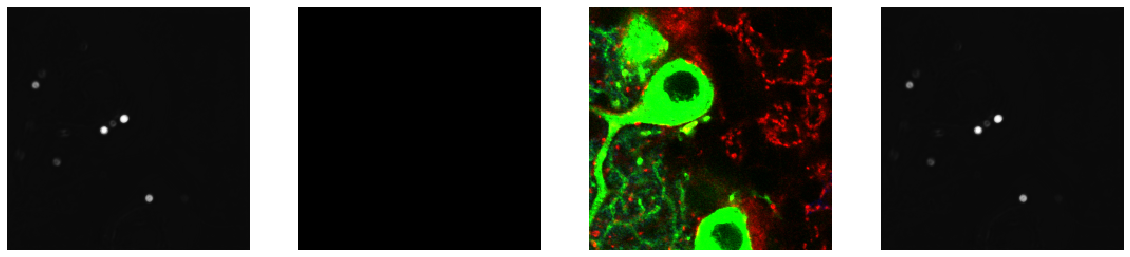

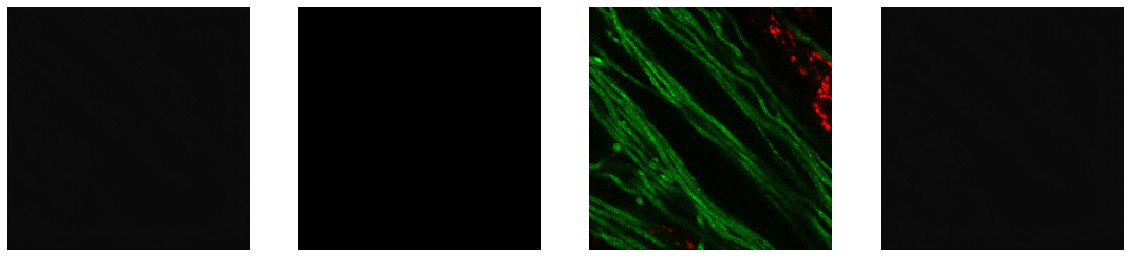

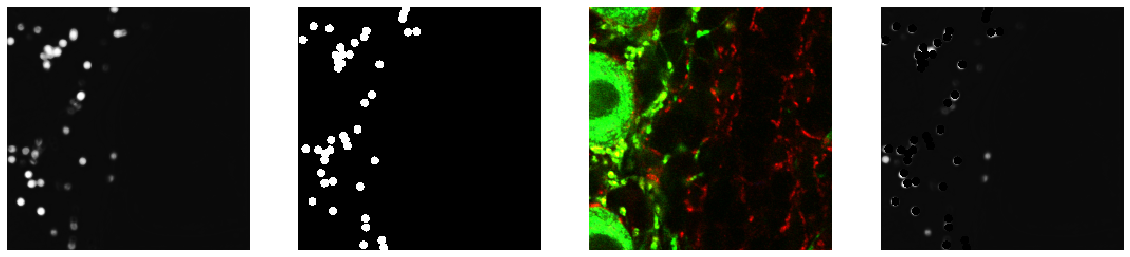

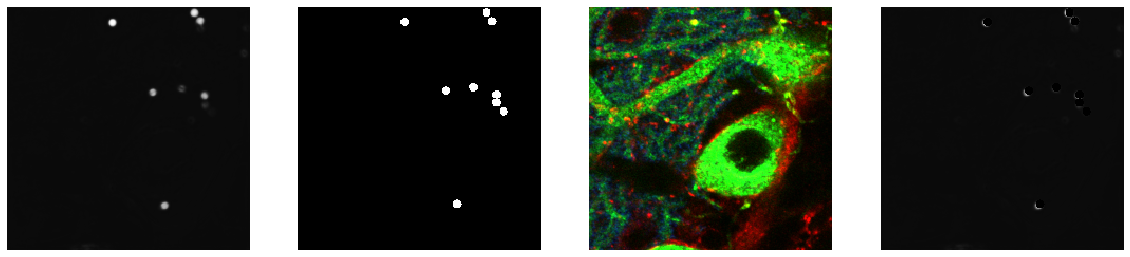

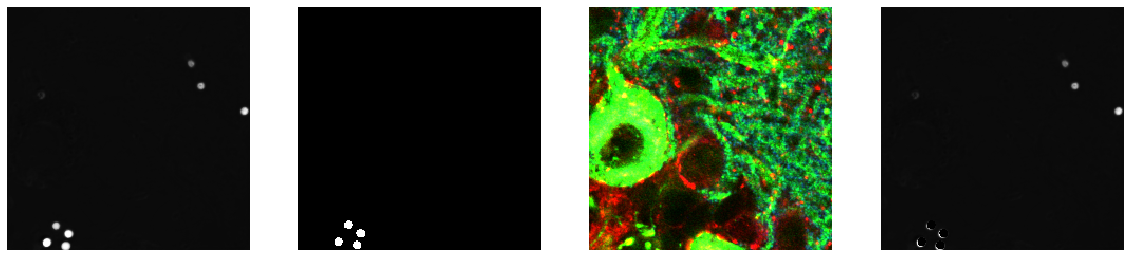

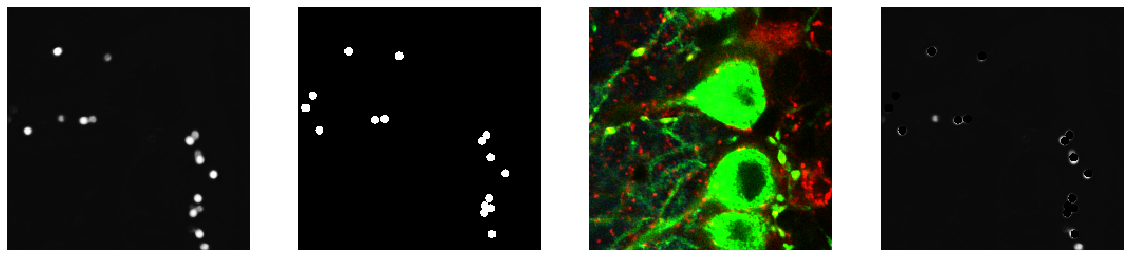

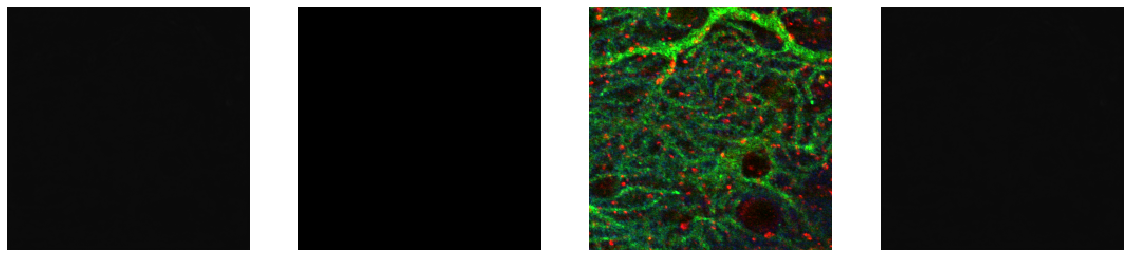

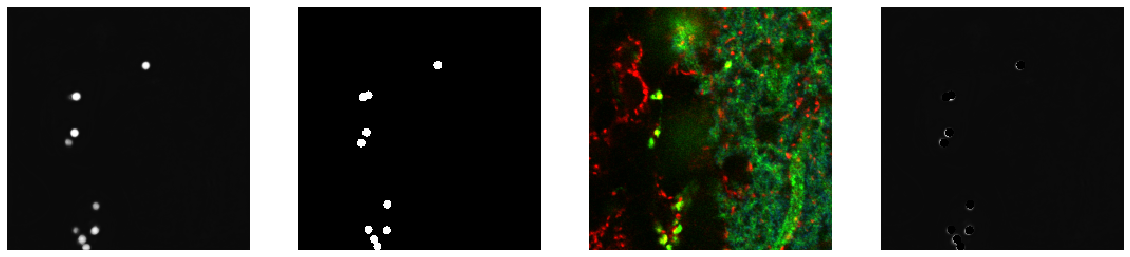

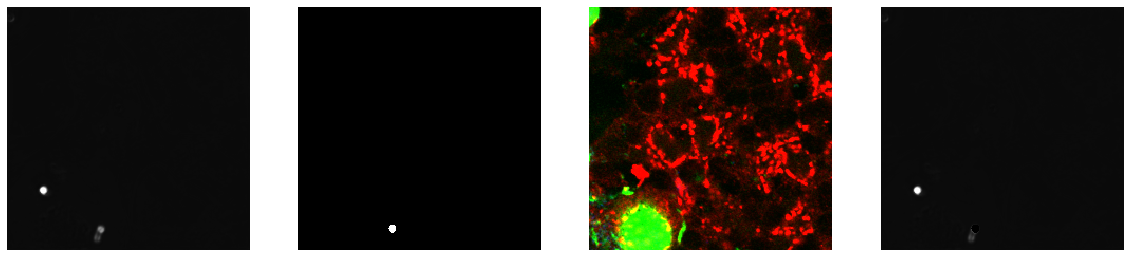

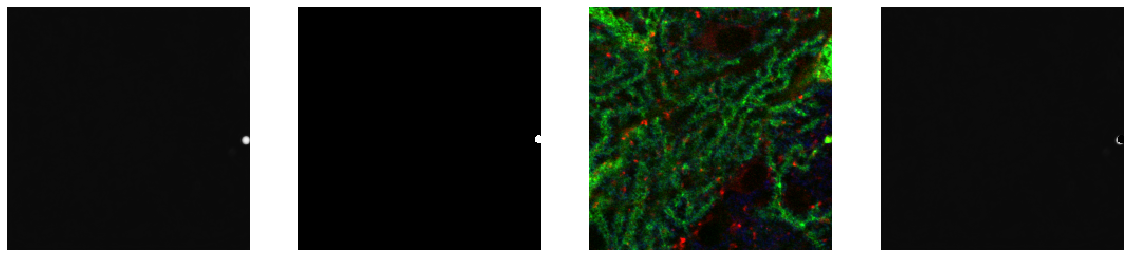

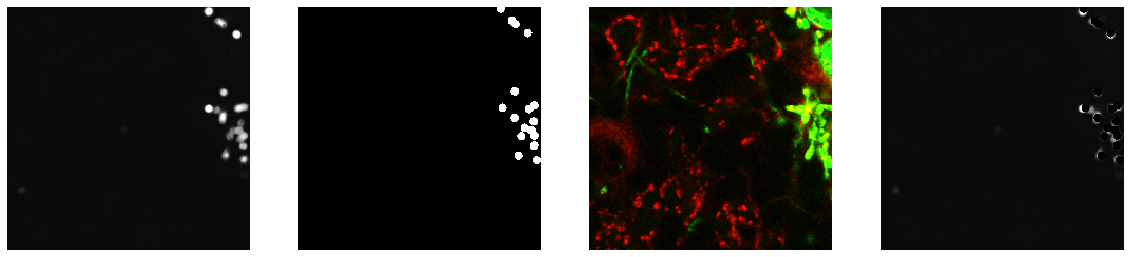

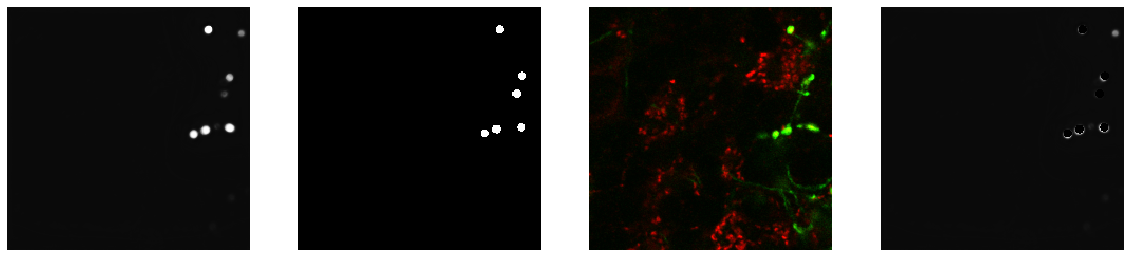

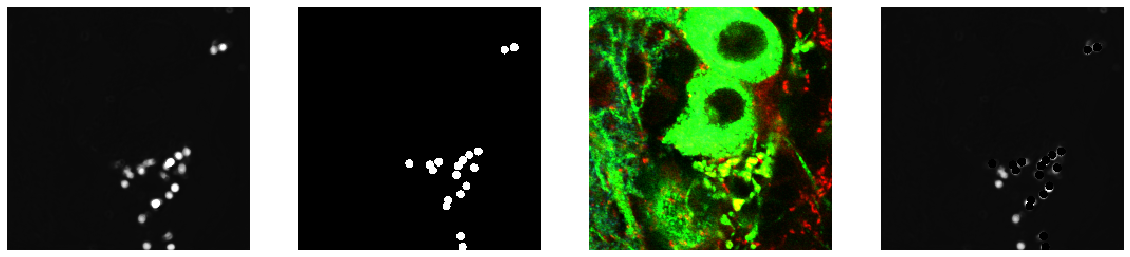

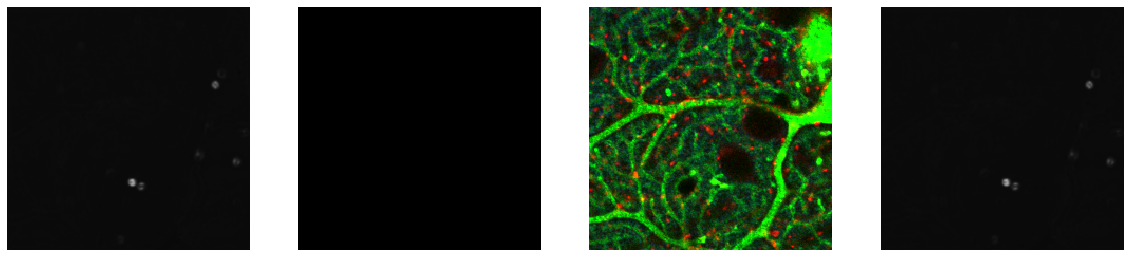

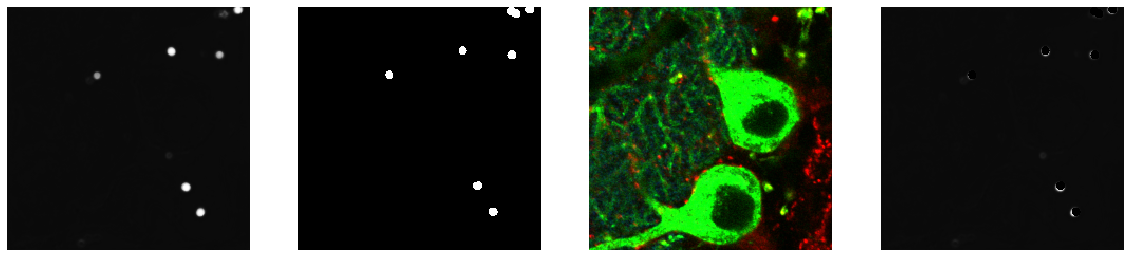

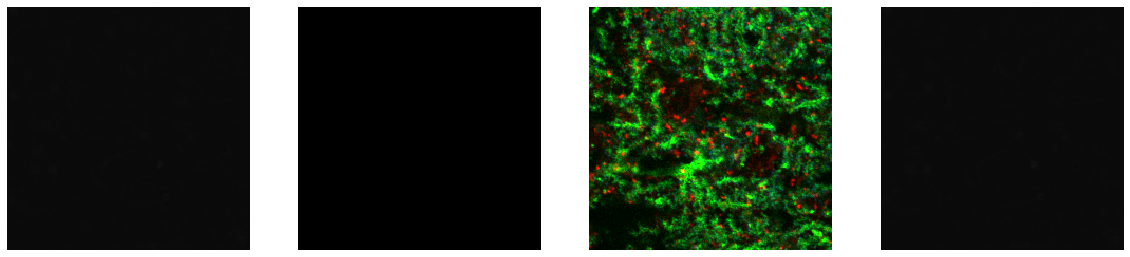

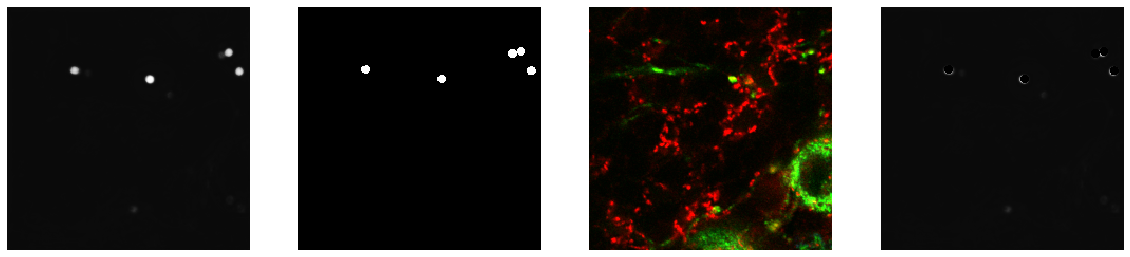

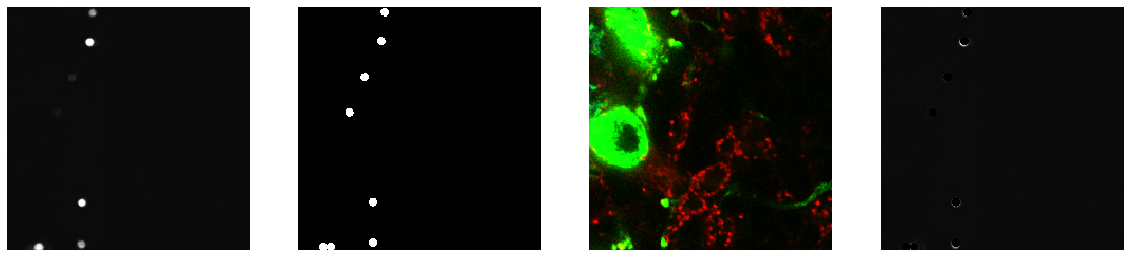

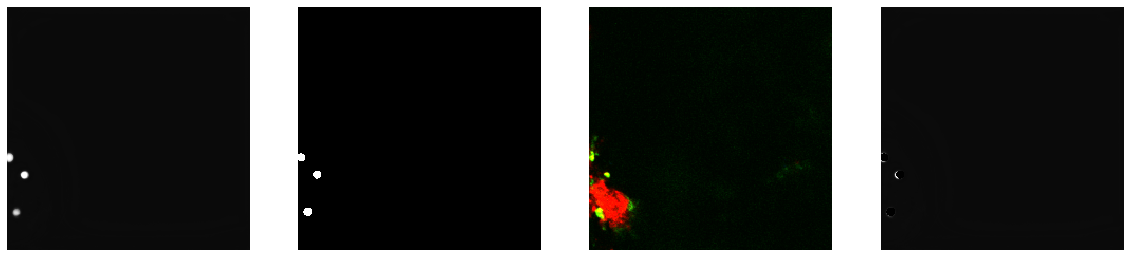

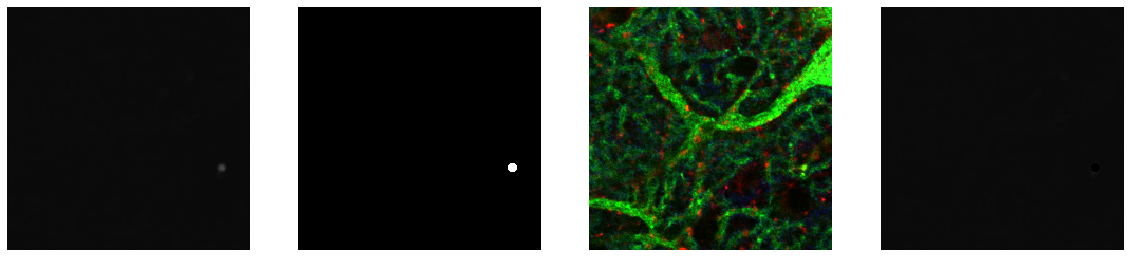

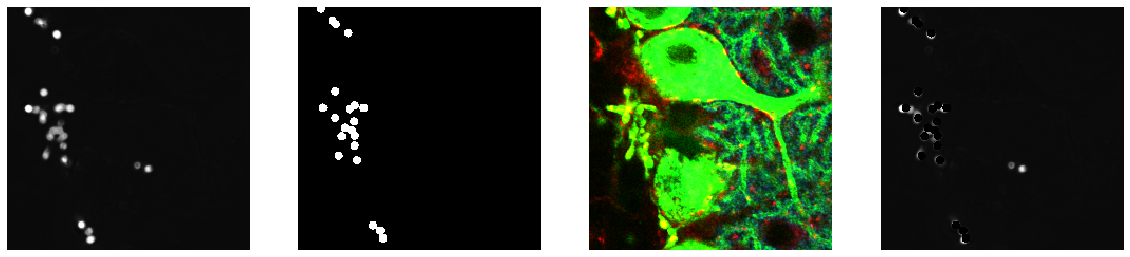

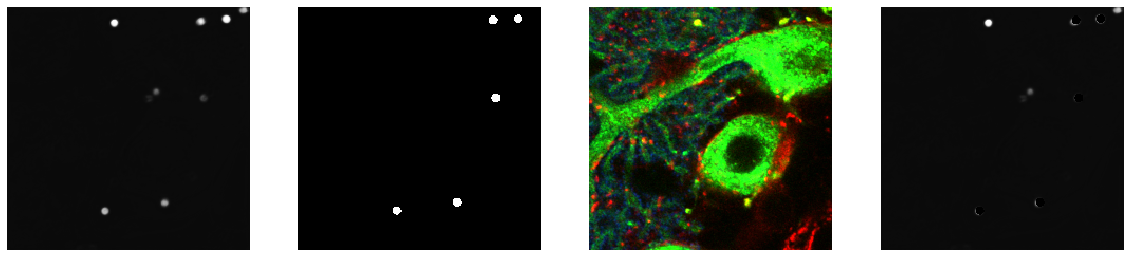

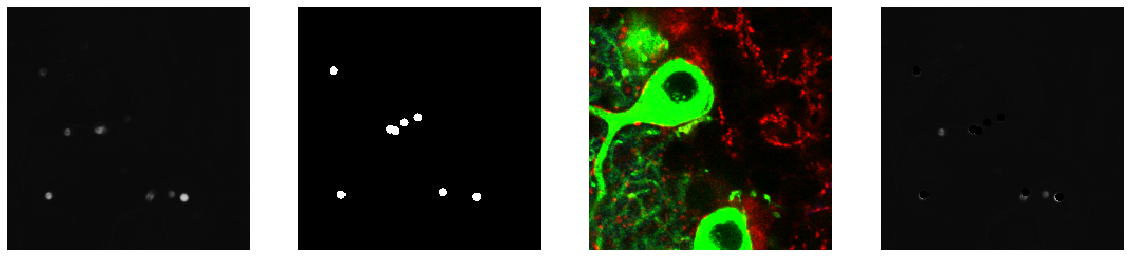

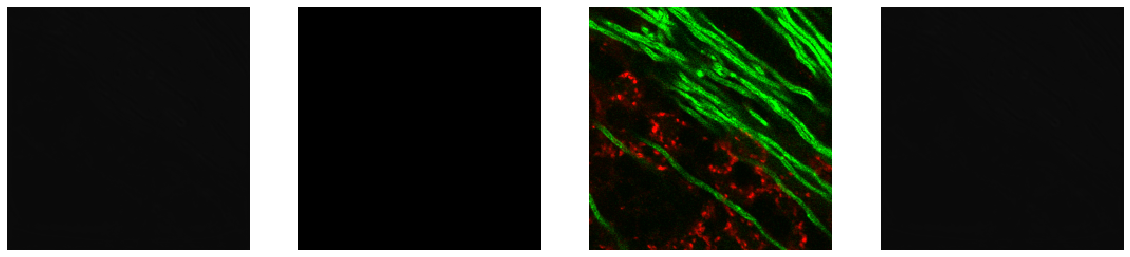

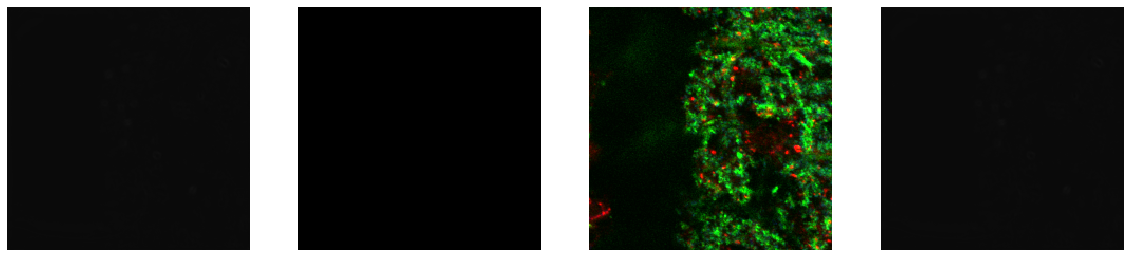

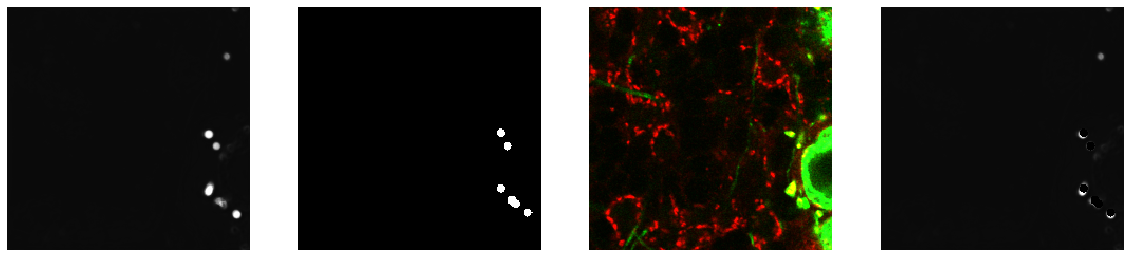

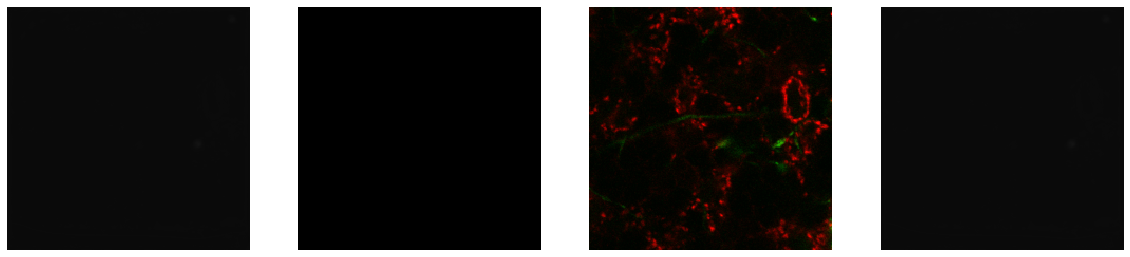

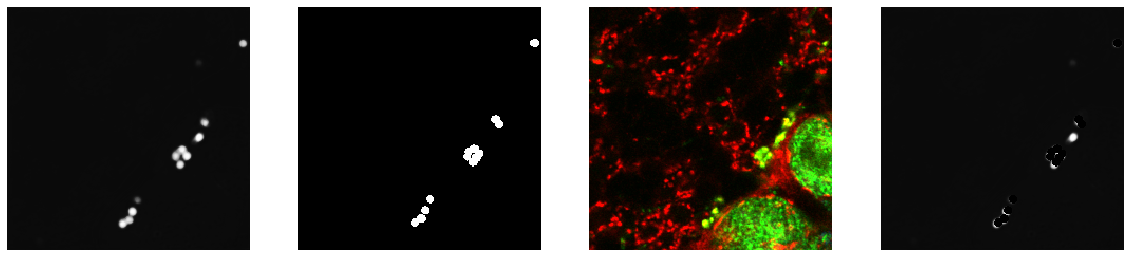

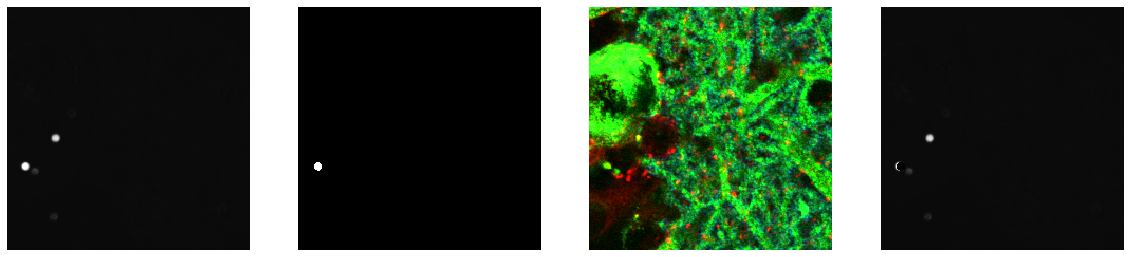

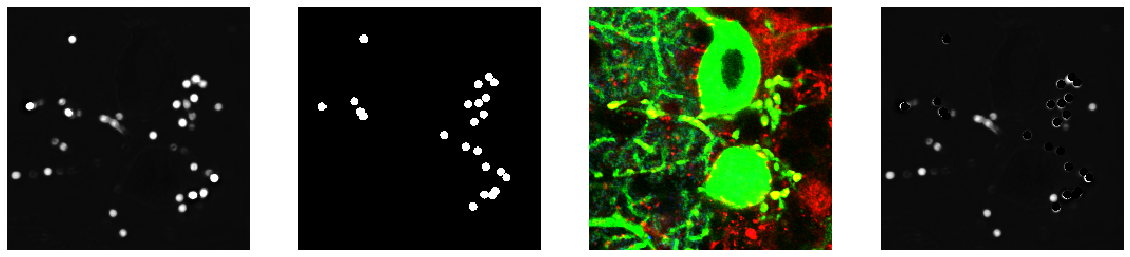

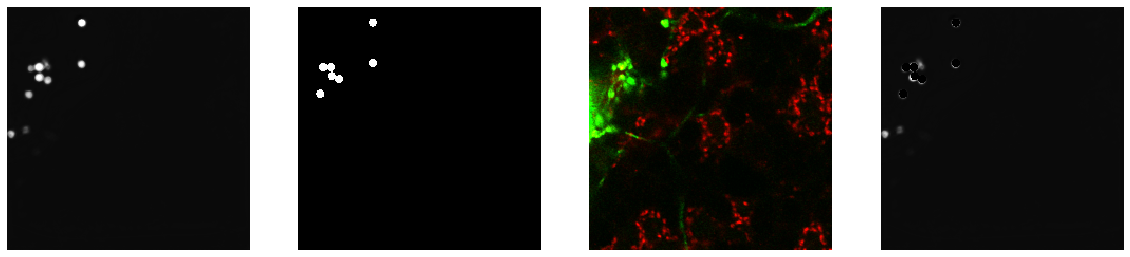

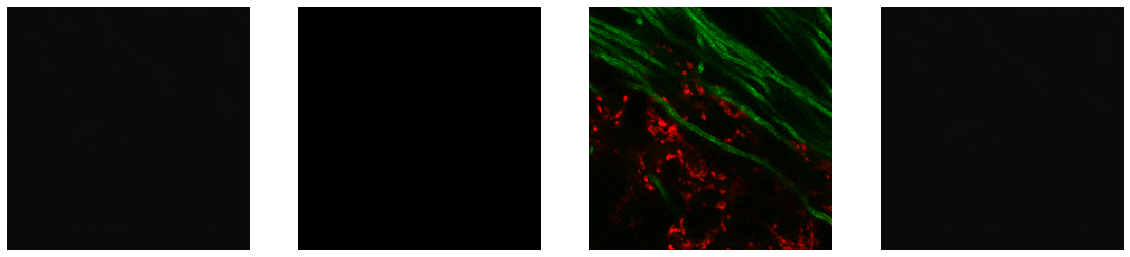

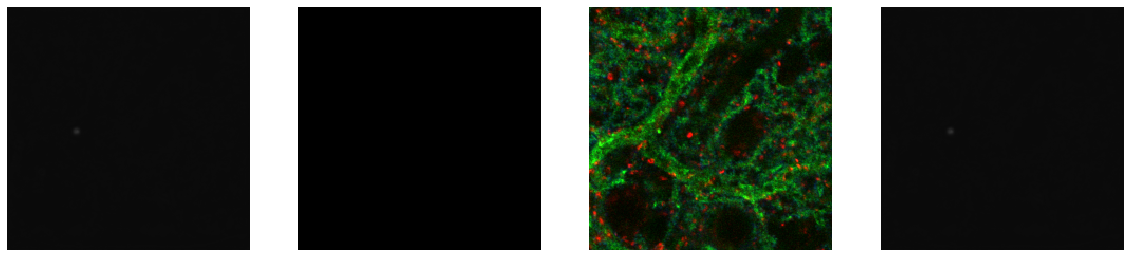

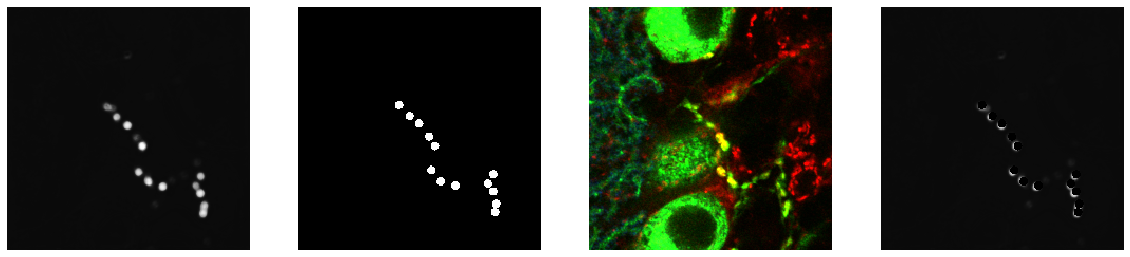

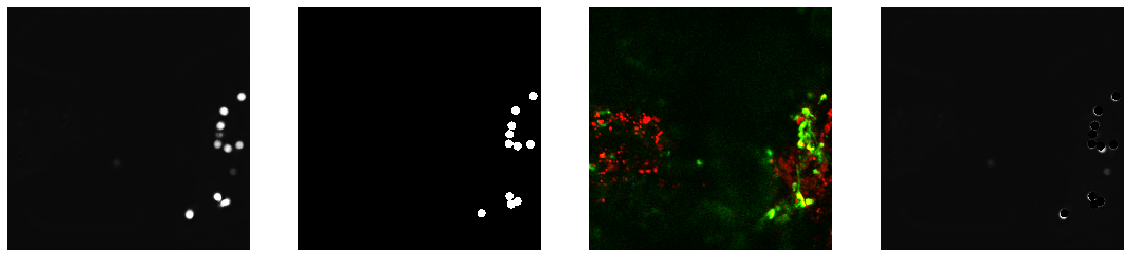

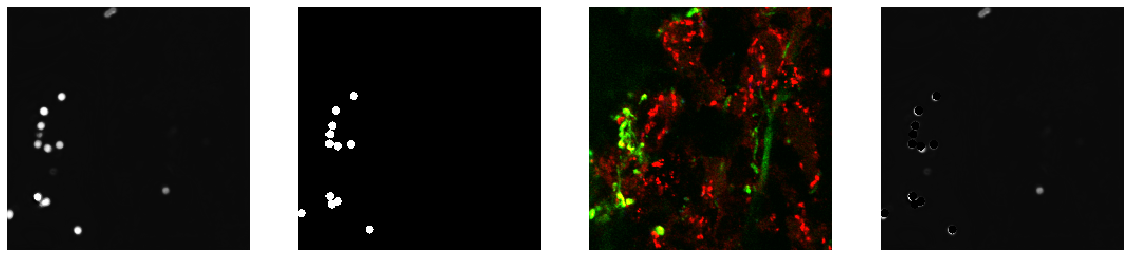

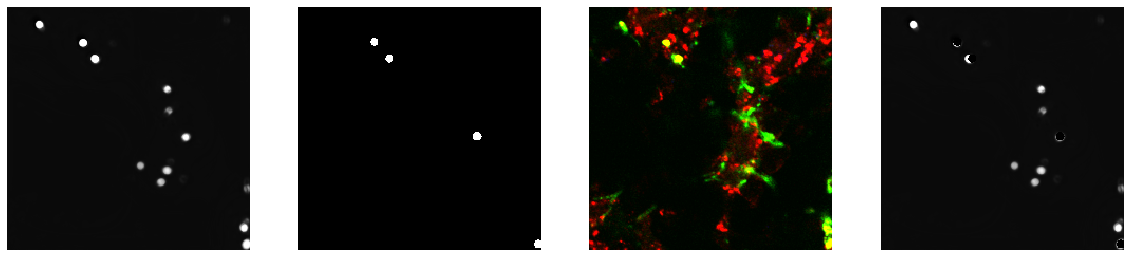

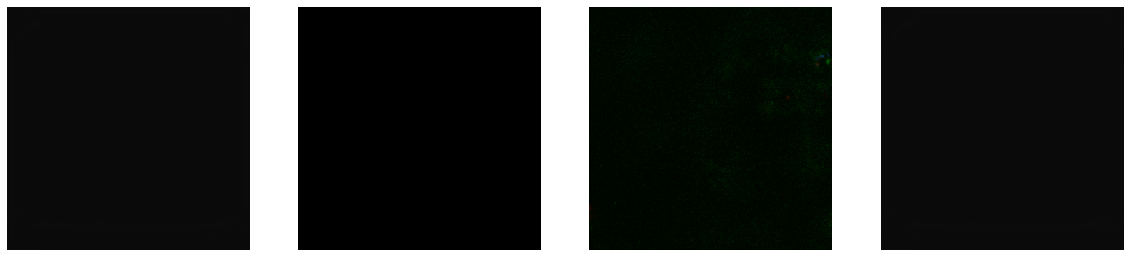

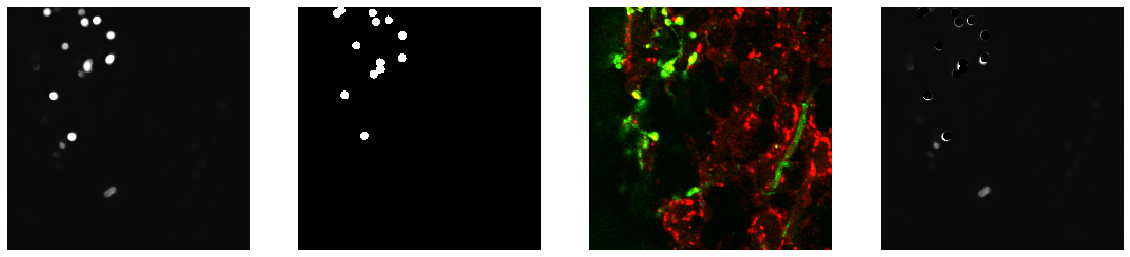

In [11]:
# view predicted masks, human annotated masks, image, and difference of masks
for j in range(0,len(testNums)):
    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.imshow(predImgs[j], cmap='gray')
    plt.clim(0,1)
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(trainingMasks[testNums[j]], cmap='gray')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(np.clip(np.transpose(trainingImages[testNums[j]],(1,2,0)),0,1))
    plt.clim(0,1)
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(predImgs[j]-trainingMasks[testNums[j]], cmap='gray')
    plt.clim(0,1)
    plt.axis('off')
    plt.show()

In [12]:
# true positives
print("true positives = " + str(truePositives/coordsLen))
# total number of predicted synapses
print("total predicted synapses = " + str(truePositives))
# total number of human annotated synapses
print("total human annotated synapses = " + str(coordsLen))
# true positives per image
print("synapses identified per image = " + str(truePos))

true positives = 0.952247191011236
total predicted synapses = 339
total human annotated synapses = 356
synapses identified per image = ['8/8', '12/13', '8/8', '7/7', '4/4', '0/0', '9/9', '8/8', '10/10', '2/2', '0/0', '0/0', '0/0', '36/43', '7/9', '4/4', '14/16', '0/0', '10/10', '1/1', '1/1', '17/17', '6/6', '18/18', '0/0', '7/8', '0/0', '5/5', '6/8', '3/3', '1/1', '21/21', '5/5', '6/8', '0/0', '0/0', '6/6', '0/0', '13/13', '1/1', '23/23', '7/7', '0/0', '0/0', '13/13', '11/11', '12/12', '4/4', '0/0', '13/13']
